In [1]:
import pandas as pd
import numpy as np
import os
import csv
import gzip
import sys
import datetime
import ast
import matplotlib.pyplot as plt
import scipy.stats as SSA
from scipy.stats import gaussian_kde

In [2]:
df_scores = pd.read_csv('../results/scores/survey_scores_perinfo.csv')

In [3]:
df_scores.columns

Index(['ResponseId', 'zipcode', 'alloc_debt', 'alloc_spend', 'alloc_save',
       'alloc_invest', 'Age', 'Risk_preference', 'score', 'presbias',
       'absolmag', 'gainloss', 'loss_gain_1', 'loss_loss_1', 'loss_gain_2',
       'loss_loss_2', 'loss_gain_3', 'loss_loss_3', 'gain_bias', 'loss_bias',
       'loss_aversion_scores', 'total_avail', 'total_realistic', 'num_items',
       'rescale_avail', 'rescale_realistic', 'agency',
       'agency_pub_trans_avail', 'agency_pub_trans_realistic',
       'agency_uber_avail', 'agency_uber_realistic', 'agency_delivery_avail',
       'agency_delivery_realistic', 'agency_grocery_avail',
       'agency_grocery_realistic', 'agency_pharma_avail',
       'agency_pharma_realistic', 'agency_docs_avail', 'agency_docs_realistic',
       'agency_online_avail', 'agency_online_realistic',
       'agency_IP_safe_avail', 'agency_IP_safe_realistic',
       'agency_remote_avail', 'agency_remote_realistic', 'regulated_agency',
       'regulated_tdscores', 'regula

In [4]:
agency_cols = ['agency_pub_trans_avail', 'agency_pub_trans_realistic',
       'agency_uber_avail', 'agency_uber_realistic', 'agency_delivery_avail',
       'agency_delivery_realistic', 'agency_grocery_avail',
       'agency_grocery_realistic', 'agency_pharma_avail',
       'agency_pharma_realistic', 'agency_docs_avail', 'agency_docs_realistic',
       'agency_online_avail', 'agency_online_realistic',
       'agency_IP_safe_avail', 'agency_IP_safe_realistic',
       'agency_remote_avail', 'agency_remote_realistic'] +['MODZCTA','modzcta_count']
df_agency = df_scores[agency_cols]

In [61]:
### there are 9 items in agencies
### not all of them are answered by all participants

In [5]:
services = ['pub_trans', 'uber', 'delivery', 'grocery', 'pharma', 'docs', 'online', 'IP_safe', 'remote']

# Loop through each service and calculate the difference between 'realistic' and 'avail'
for service in services:
    avail_col = f'agency_{service}_avail'
    realistic_col = f'agency_{service}_realistic'
    diff_col = f'agency_{service}_diff'
    
    # Calculate the difference and store in a new column
    df_agency.loc[:,diff_col] = df_agency[realistic_col] - df_agency[avail_col]

/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_41993/3605411233.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agency.loc[:,diff_col] = df_agency[realistic_col] - df_agency[avail_col]
/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_41993/3605411233.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agency.loc[:,diff_col] = df_agency[realistic_col] - df_agency[avail_col]
/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_41993/3605411233.py:10: SettingWithCopyWarn

In [6]:
for service in services:
    diff_col = f'agency_{service}_diff'
    group_col = f'agency_{service}_group'

    # Define the conditions for grouping
    conditions = [
        df_agency[diff_col] < 0,   # Group 1: diff < 0
        df_agency[diff_col] == 0,  # Group 2: diff == 0
        df_agency[diff_col] > 0,   # Group 3: diff > 0
        df_agency[diff_col].isna() # Group 4: NaN
    ]
    
    # Define the group numbers
    groups = [1, 2, 3, 4]
    
    # Use np.select to assign the group based on the conditions
    df_agency.loc[:, group_col] = np.select(conditions, groups, default=np.nan)

/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_41993/2155502617.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agency.loc[:, group_col] = np.select(conditions, groups, default=np.nan)
/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_41993/2155502617.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agency.loc[:, group_col] = np.select(conditions, groups, default=np.nan)
/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_41993/2155502617.py:17: SettingWithCopyWarn

In [7]:
diff_values_group_1 = [-4, -3, -2, -1]
diff_values_group_3 = [1, 2, 3, 4]

# Create dictionaries to store the counts for each service and each group
data_group_1 = {service: {val: 0 for val in diff_values_group_1} for service in services}
data_group_2 = {service: 0 for service in services}  # Single group for diff == 0
data_group_3 = {service: {val: 0 for val in diff_values_group_3} for service in services}

df_group_1 = df_agency[df_agency[[f'agency_{service}_group' for service in services]] == 1]

for service in services:
    diff_col = f'agency_{service}_diff'
    group_col = f'agency_{service}_group'
    
    # Group 1: diff < 0
    for val in diff_values_group_1:
        data_group_1[service][val] = df_agency.loc[df_agency[group_col] == 1, diff_col].value_counts().get(val, 0)
    
    # Group 2: diff == 0
    data_group_2[service] = df_agency.loc[df_agency[group_col] == 2, diff_col].shape[0]
    
    # Group 3: diff > 0
    for val in diff_values_group_3:
        data_group_3[service][val] = df_agency.loc[df_agency[group_col] == 3, diff_col].value_counts().get(val, 0)

In [71]:
df_agency.to_csv('../results/scores/agency_diff.csv', index=False)

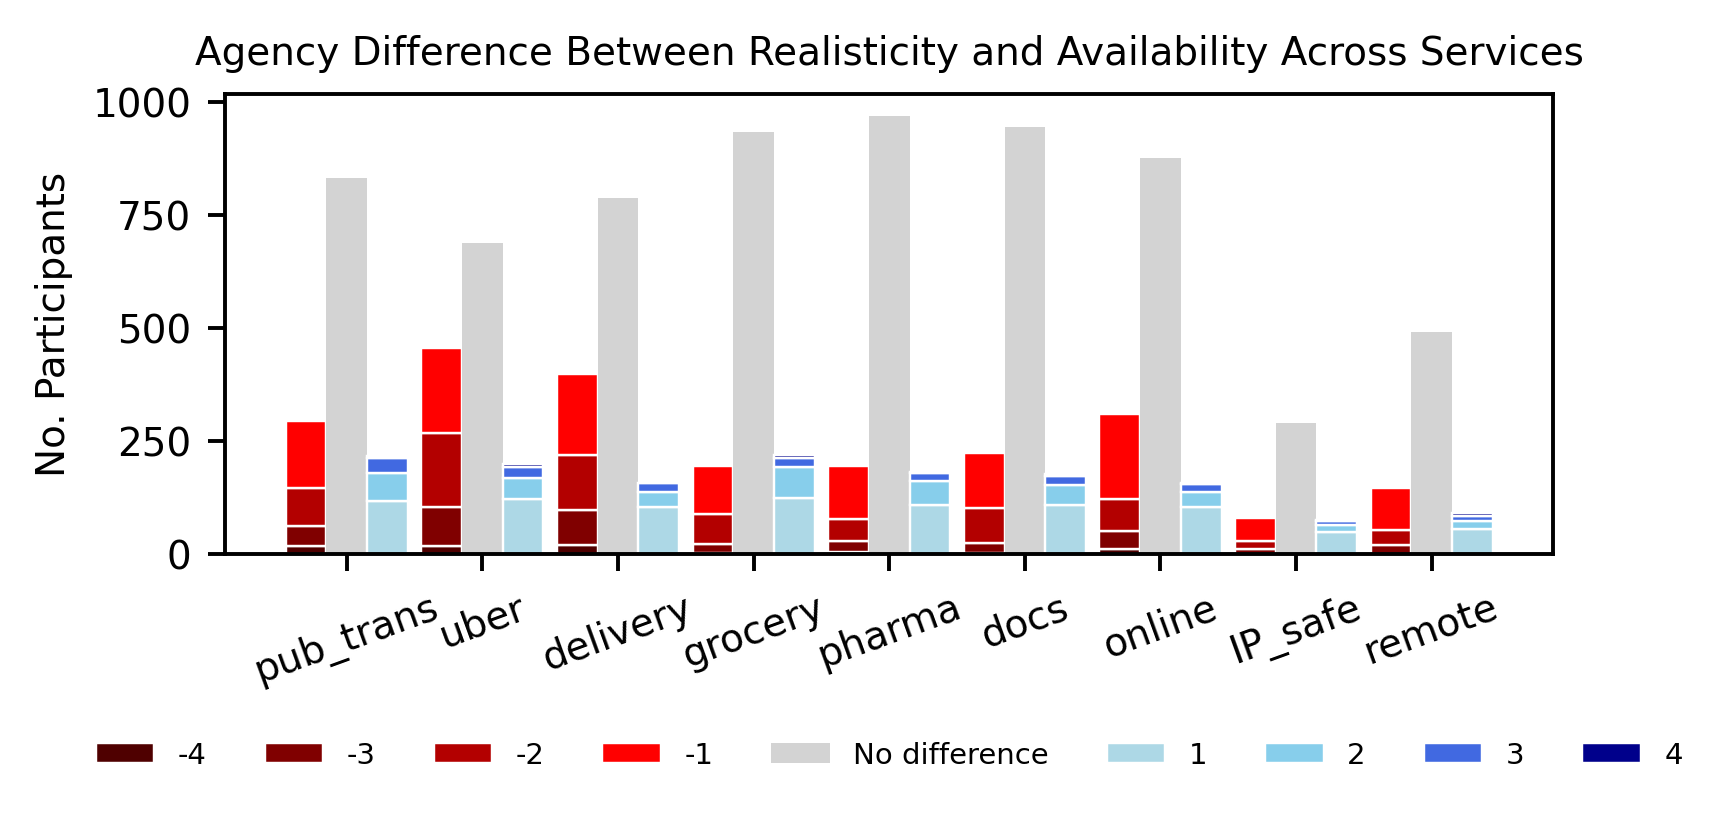

In [115]:
fig, ax = plt.subplots(figsize=(5., 2.7),dpi=350)

# Define color schemes for each group
colors_group_1 = ['#4f0000', '#800000', '#b30000', '#ff0000']  # Darker to lighter red for Group 1
color_group_2 = '#d3d3d3'   # Single green color for Group 2
colors_group_3 = ['#ADD8E6','#87CEEB','#4169E1','#00008B']   # Darker to lighter blue for Group 3

# Define bar positions
bar_width = 0.3
indices = np.arange(len(services))

# Plot Group 1 (stacked bar)
bottom_group_1 = np.zeros(len(services))
for i, val in enumerate(diff_values_group_1):
    counts_group_1 = [data_group_1[service][val] for service in services]
    ax.bar(indices - bar_width, counts_group_1, bar_width, bottom=bottom_group_1, color=colors_group_1[i], label=f'{val}',edgecolor='white', linewidth=0.5)
    bottom_group_1 += counts_group_1

# Plot Group 2 (single color bar)
counts_group_2 = [data_group_2[service] for service in services]
ax.bar(indices, counts_group_2, bar_width, color=color_group_2, label='No difference')

# Plot Group 3 (stacked bar)
bottom_group_3 = np.zeros(len(services))
for i, val in enumerate(diff_values_group_3):
    counts_group_3 = [data_group_3[service][val] for service in services]
    ax.bar(indices + bar_width, counts_group_3, bar_width, bottom=bottom_group_3, color=colors_group_3[i], label=f'{val}',edgecolor='white', linewidth=0.5)
    bottom_group_3 += counts_group_3

# Add labels, title, and legend
ax.set_ylabel('No. Participants', fontsize=8)
ax.set_title('Agency Difference Between Realisticity and Availability Across Services', size=8)
ax.set_xticks(indices)
ax.tick_params(axis='both', labelsize=8)
ax.set_xticklabels(services, fontsize=8, rotation=20)
ax.legend(bbox_to_anchor=(0.5, -0.35), loc='upper center', ncol=9,frameon=False, fontsize=6)

plt.tight_layout()
plt.savefig('../results/scores/agency_diff_hist.png', bbox_inches='tight',pad_inches=0,dpi=350)

In [9]:
mean_diffs_by_modzcta = df_agency.groupby('MODZCTA')[[f'agency_{service}_diff' for service in services]].mean()

In [31]:
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

gdf = gpd.read_file('../Data/geography_data/MODZCTA_2010.shp')
gdf['MODZCTA'] = gdf['MODZCTA'].astype(np.int64)
gdf_merged = gdf.merge(mean_diffs_by_modzcta, on='MODZCTA', how='left')

# mean_diffs_by_modzcta

In [32]:
used_mod = df_scores[df_scores['modzcta_count'] >=15]['MODZCTA'].unique()
highlight_indices = gdf_merged.index[gdf_merged['MODZCTA'].isin(used_mod)].tolist()
highlight_gdf = gdf_merged.iloc[highlight_indices]

In [116]:
service_title_dic = {'pub_trans':'Public Transportation', 'uber':'Ride Sharing Apps', 'delivery':'Food Delivery', 'grocery':'Grocery Stores', 'pharma':'Pharmacies', 'docs':'Doctors/Healthcare', 'online':'Online Shopping', 'IP_safe': 'Safe In-Person Attendance', 'remote': 'Remote Activities'}

agency_pub_trans_diff
agency_uber_diff
agency_delivery_diff
agency_grocery_diff
agency_pharma_diff
agency_docs_diff
agency_online_diff
agency_IP_safe_diff
agency_remote_diff


/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_41993/2132152708.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Leave space for the colorbar #rect=[0, 0, 0., 1]


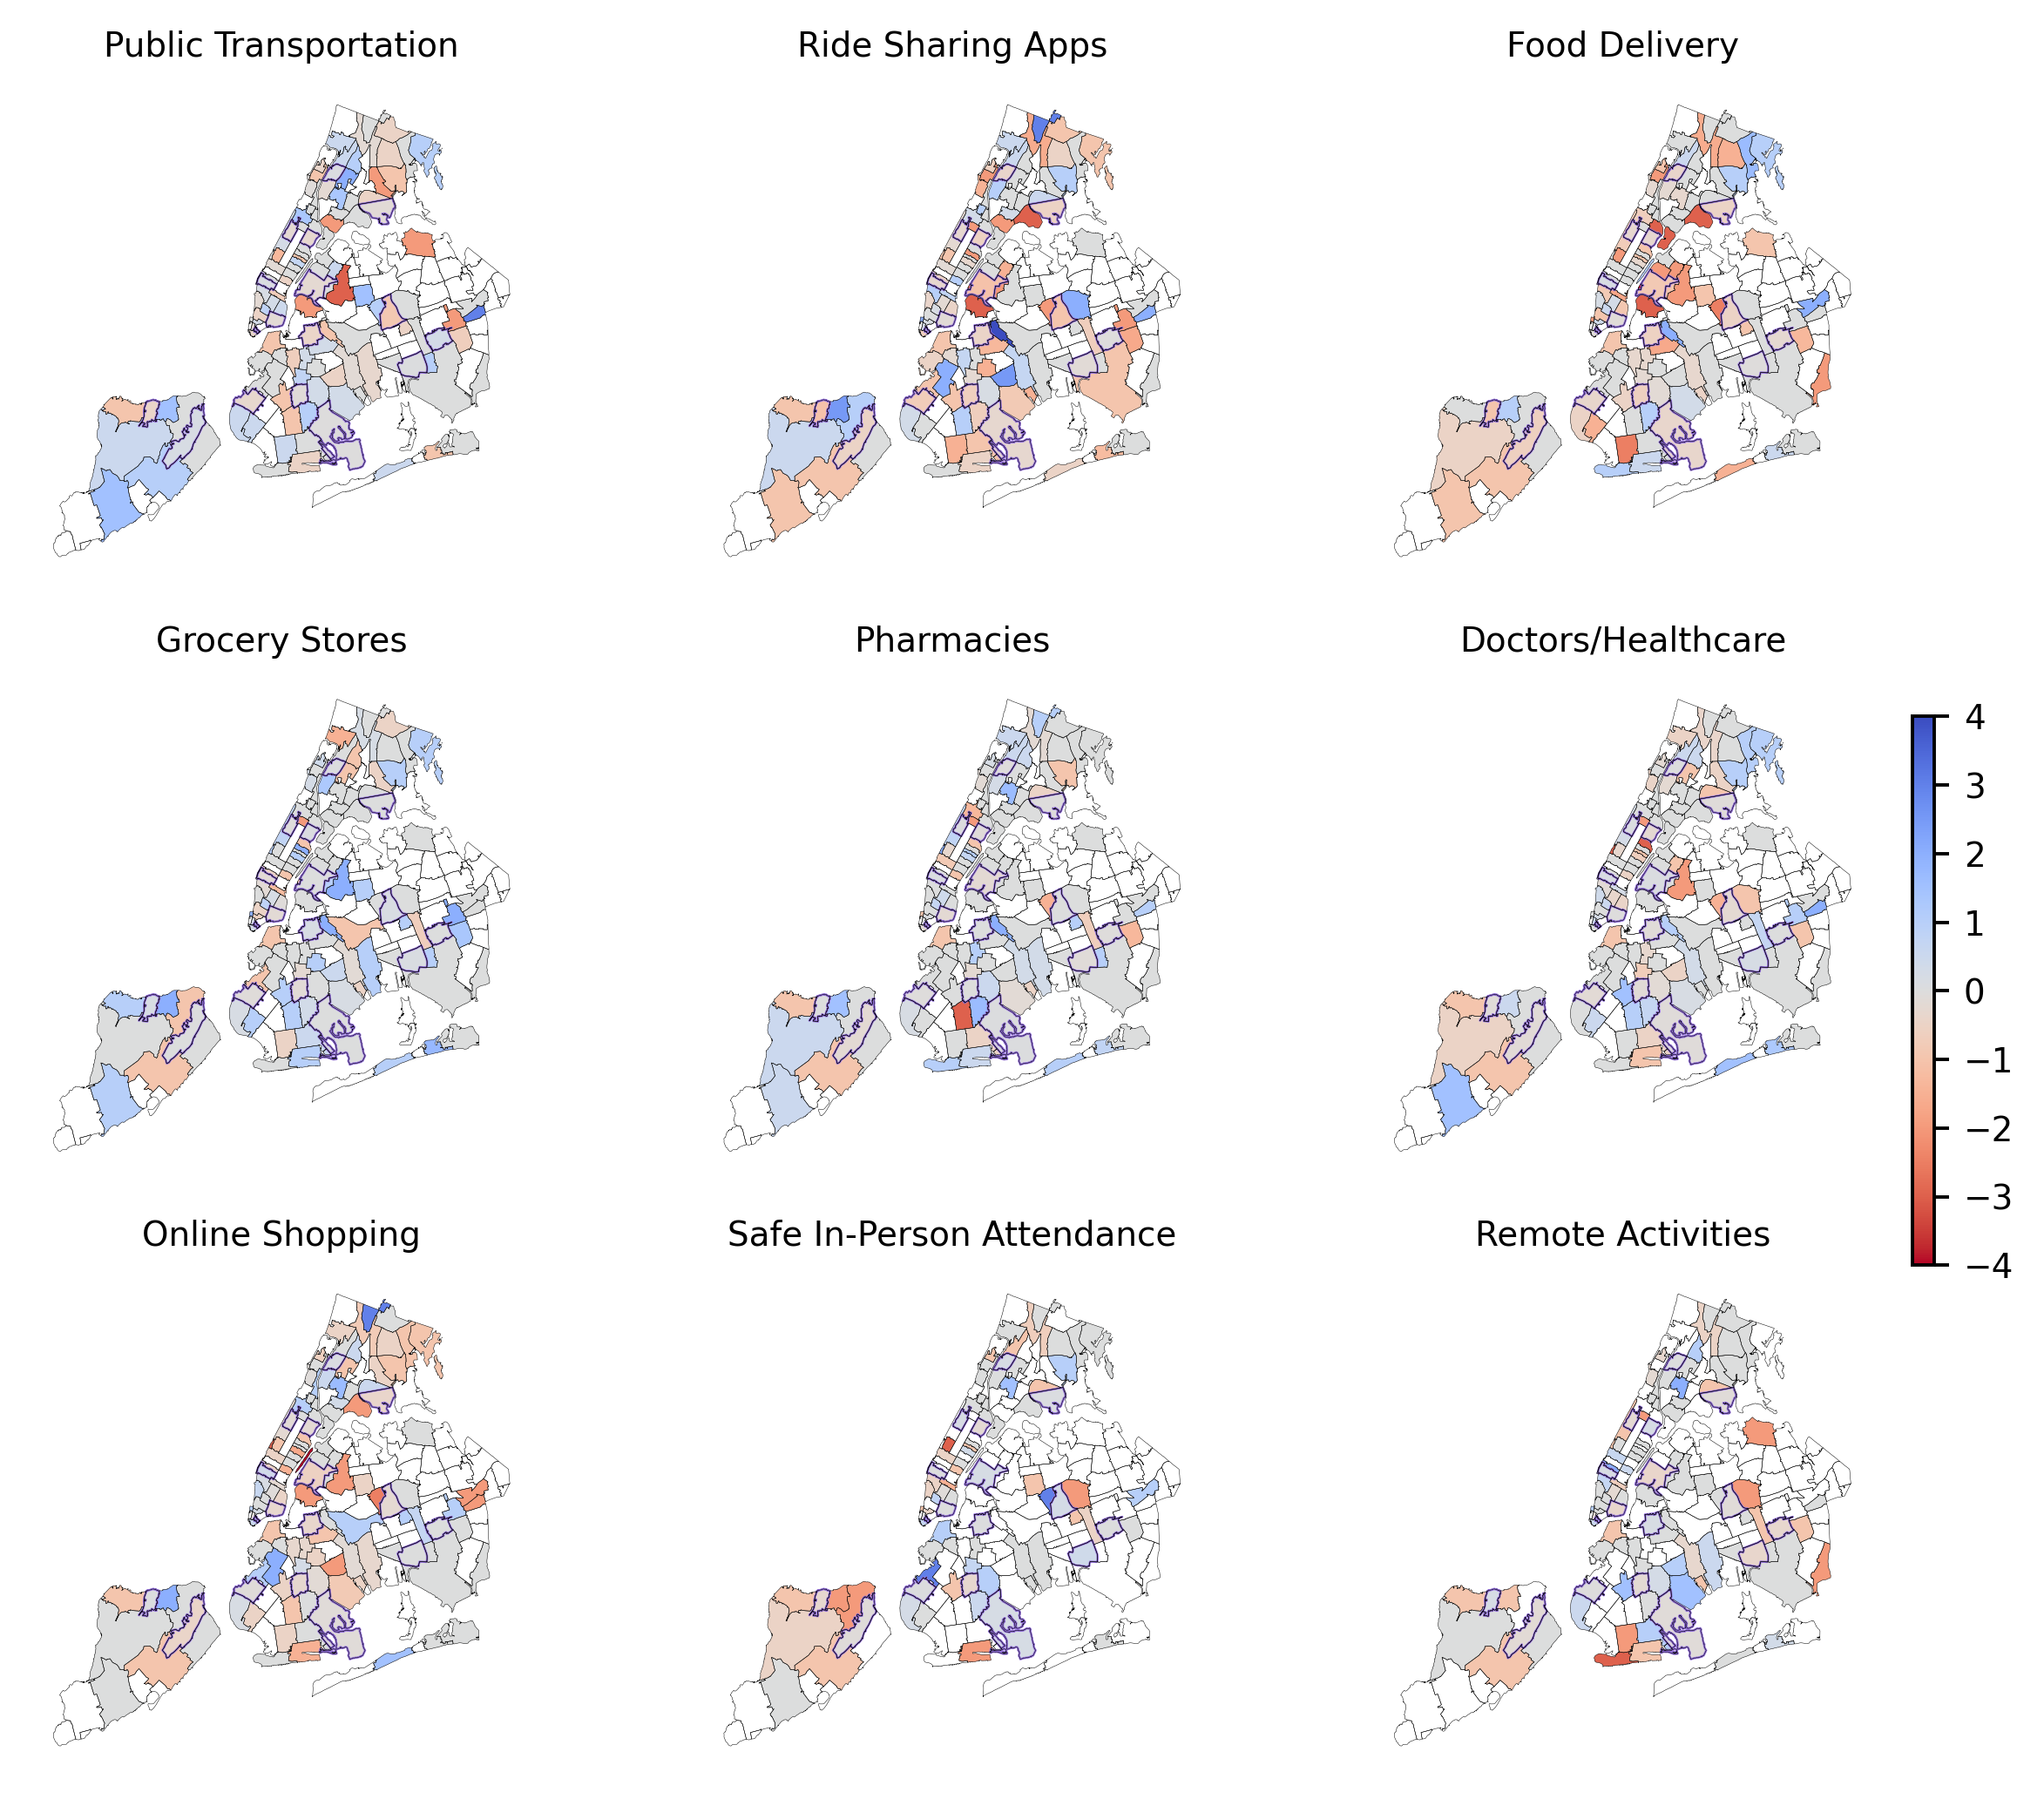

In [117]:
fig, axes = plt.subplots(3, 3, figsize=(7., 6), dpi=350)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop over each service and plot its map in the corresponding subplot
for i, service in enumerate(services):
    ax = axes[i]
    
    # The column to visualize
    diff_col = f'agency_{service}_diff'
    print(diff_col)
    # Plot the map with the mean differences as color
    # gdf.plot(ax=ax, color='white', edgecolor='black',linewidth=0.1)
    gdf.boundary.plot(ax=ax,edgecolor='black',linewidth=0.1)
    gdf_merged_plot = gdf_merged.plot(column=diff_col, ax=ax, cmap='coolwarm_r', edgecolor='none', vmin=-4, vmax=+4)
    highlight_gdf.plot(ax=ax, color='none', edgecolor='mediumpurple', linewidth=0.5)
    # Set the title for each subplot
    ax.set_title(f'{service_title_dic[service]}',fontsize=8)
    ax.axis('off')  # Turn off axis for clean map visualization

    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    # fig = ax.figure
    # cb_ax = fig.axes[1]
    
    # cb_ax.tick_params(labelsize=8)

# Hide any remaining empty subplots
for j in range(len(services), 9):
    fig.delaxes(axes[j])

cbar_ax = fig.add_axes([0.95, 0.3, 0.01, 0.3])  # Adjust position [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=plt.Normalize(vmin=-4, vmax=4))
sm._A = []  # Dummy mappable to use for colorbar
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=8)  # Set colorbar font size

# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=0., hspace=0.)
plt.tight_layout()  # Leave space for the colorbar #rect=[0, 0, 0., 1]
plt.savefig('../results/scores/agency_diff_map.png', bbox_inches='tight',pad_inches=0, dpi=350)


In [73]:
gdf_merged.columns

Index(['MODZCTA', 'label', 'geometry', 'agency_pub_trans_diff',
       'agency_uber_diff', 'agency_delivery_diff', 'agency_grocery_diff',
       'agency_pharma_diff', 'agency_docs_diff', 'agency_online_diff',
       'agency_IP_safe_diff', 'agency_remote_diff'],
      dtype='object')

In [106]:
gdf_merged['agency_diff_sum'] = gdf_merged[[f'agency_{service}_diff' for service in services[:7]]].sum(axis=1, min_count=1)

/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_41993/4202567116.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


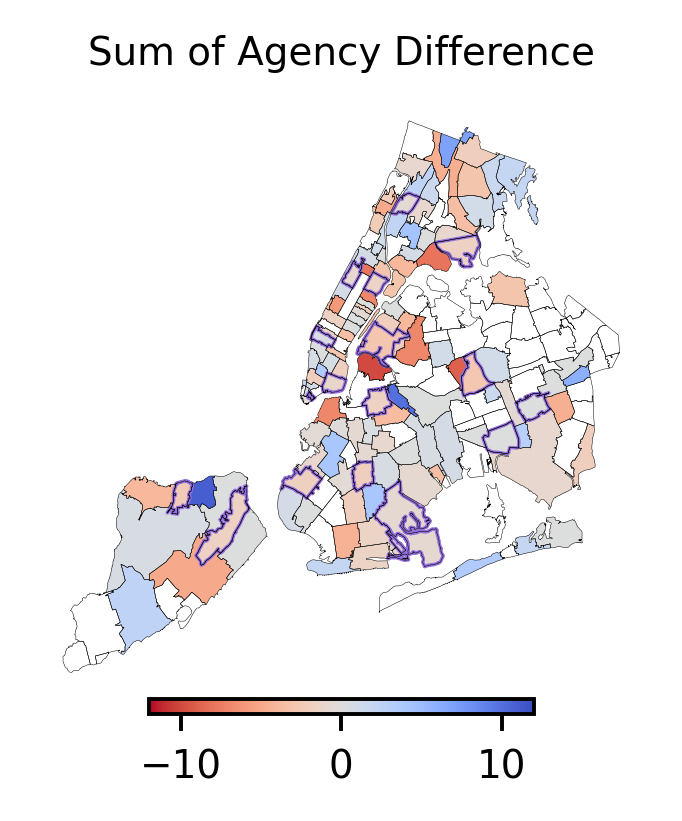

In [114]:
fig, ax = plt.subplots(1,1,figsize=(2.2, 2.2), dpi=350)

# The column to visualize
diff_col = 'agency_diff_sum'
# Plot the map with the mean differences as color
# gdf.plot(ax=ax, color='white', edgecolor='black',linewidth=0.1)
gdf.boundary.plot(ax=ax,edgecolor='black',linewidth=0.1)
gdf_merged_plot = gdf_merged.plot(column=diff_col, ax=ax, cmap='coolwarm_r', edgecolor='none', vmin=-12, vmax=+12)
highlight_gdf.plot(ax=ax, color='none', edgecolor='mediumpurple', linewidth=0.7)
# Set the title for each subplot
ax.set_title(f'Sum of Agency Difference',fontsize=8)
ax.axis('off')
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # Adjust position [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=plt.Normalize(vmin=-12, vmax=12))
sm._A = []  # Dummy mappable to use for colorbar
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=8)  # Set colorbar font size
plt.tight_layout() 
plt.savefig('../results/scores/agency_diff_sum_map.png', bbox_inches='tight',pad_inches=0.0,dpi=350)